# Final Project - Road Detection
### 	Bruno Gazoni 7585037<br> 	Matheus Steigenberg Populim 10734710<br> Rafael Ceneme 	9898610<br> 	Bruno Baldissera  10724351

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Reading the input image

In [2]:
name1 = "img10.png"
A = imageio.imread(name1)
print(A.shape)

(1500, 1500, 3)


## We now declare the useful normalization function and the gamma correction and average filtering functions

In [3]:
#função de normalização
def normalize(A, x):
    a = A.min()
    b = A.max()
    A = ((A-a)/(b-a))*x
    return A

In [4]:
#função para correção gamma
def gamma_correction(A,gamma):
    B = np.zeros((A.shape))
    B = 255*(np.power(A/255.0,1.0/gamma))
    B = normalize(B, 255)
    return B

In [5]:
#função para obter filtro de média
def get_average_filter(A):
    N = A.shape[0]
    n = 100
    C = np.zeros((N//n,N//n),dtype=np.float32)

    for i in range(N//n):
        for j in range(N//n):
            C[i,j] = np.average(A[i*n:(i+1)*n,j*n:(j+1)*n])

    C = np.kron(C,np.ones((n,n)))
    return C

## On our first test we apply the average filter in the image, normalize its values to the interval $[0,1]$ and apply the gamma correction.

In [6]:
# Converte para o sistema de cores HSV
img_hsv = mpl.colors.rgb_to_hsv(A)

# Inverte o valor H da imagem
teste = 1-img_hsv[:,:,1]

media = get_average_filter(teste)

teste = normalize(teste-media, 1)

teste_gamma = gamma_correction(teste, 0.8)

Text(0.5, 1.0, 'Average filter + gamma correction')

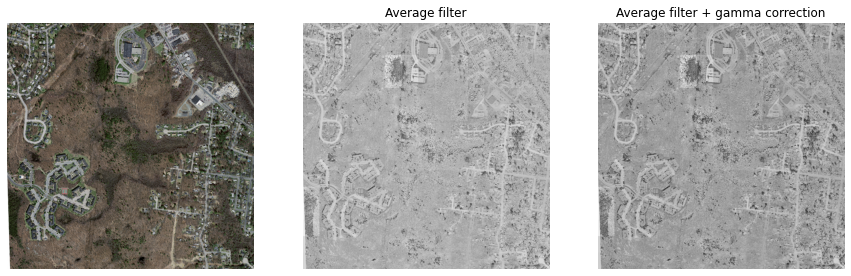

In [7]:
plt.figure(figsize=(15,15))
plt.subplot(131); plt.imshow(A, cmap="gray"); plt.axis('off')
plt.subplot(132); plt.imshow(teste, cmap="gray"); plt.axis('off'); plt.title('Average filter')
plt.subplot(133); plt.imshow(teste_gamma, cmap="gray"); plt.axis('off'); plt.title('Average filter + gamma correction')

## We now perform thresholding on the image obtained after earlier processing to select the candidate road pixels.

## Our thresholding method additionally uses the V value on the HSV system, such that only pixels with V value in $[L_1, L_2]$ are chosen.

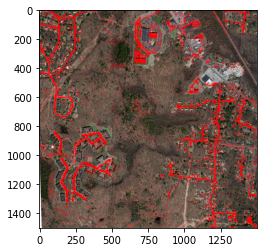

In [8]:
# Colocamos na variável 'valor' os valores V da imagem
valor = img_hsv[:,:,2]

f_tr = np.ones(teste.shape).astype(np.uint8)
# setting to 0 the pixels below the threshold
# f_tr = A[:,:,0]

# Adicionamos a restrição do valor V estar no intervalo [L1, L2]
L1 = 200
L2 = 90

B = A
B[(np.where((teste_gamma > 180) & (valor < L1) & (valor > L2)))] = [255,0,0]

plt.imshow(B)
plt.show()

In [9]:
image = gamma_correction(B[:,:,0], 0.8)

## In the search of new methods we start with the Otsu threshold method, which also uses the histogram of the image, and achieves a visibly better result than the simple one used earlier.

In [10]:
def thresholding(f, L):
    # create a new image with ones
    f_tr = np.ones(f.shape).astype(np.uint8)
    # setting to 0 the pixels below the threshold
    f_tr[np.where(f < L)] = 0
    return f_tr

In [11]:
def otsu_threshold(img, max_L):
    M = np.product(img.shape)
    min_var = []
    hist_t,_ = np.histogram(img, bins=256, range=(0,256))
    
    img_t = thresholding(img, 0)
    
    for L in np.arange(1, max_L):
        img_ti = thresholding(img, L)
        # computing weights
        w_a = np.sum(hist_t[:L])/float(M)
        w_b = np.sum(hist_t[L:])/float(M)
        # computing variances
        sig_a = np.var(img[np.where(img_ti == 0)])
        sig_b = np.var(img[np.where(img_ti == 1)])
        
        min_var = min_var + [w_a*sig_a + w_b*sig_b]
        
    img_t = thresholding(img, np.argmin(min_var))
    
    return img_t, np.argmin(min_var)

Text(0.5, 1.0, 'Otsu threshold (154)')

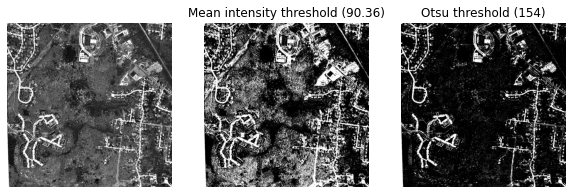

In [12]:
img_o, OL = otsu_threshold(image, 255)
hist_o,_ = np.histogram(img_o*255, bins=256, range=(0,256))

mean_v = np.mean(image)
img_t = thresholding(image, mean_v)

plt.figure(figsize=(10,15))
plt.subplot(131); plt.imshow(image,cmap="gray"); plt.axis('off')
plt.subplot(132); plt.imshow(img_t, cmap="gray"); plt.axis('off'); plt.title('Mean intensity threshold (%.2f)' % (mean_v))
plt.subplot(133); plt.imshow(img_o, cmap="gray"); plt.axis('off'); plt.title('Otsu threshold (%d)' % (OL))

In [13]:
!pip install scikit-image

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


## We apply the Hough transformation on our image, using the line shape as parameter, as it is geometrically close to road segments.

## But first we use the Canny border detection method in order to highlight the road border regions and enhance the performance of the Hough transform (its standalone effect is exhibited in the middle image).

In [14]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line

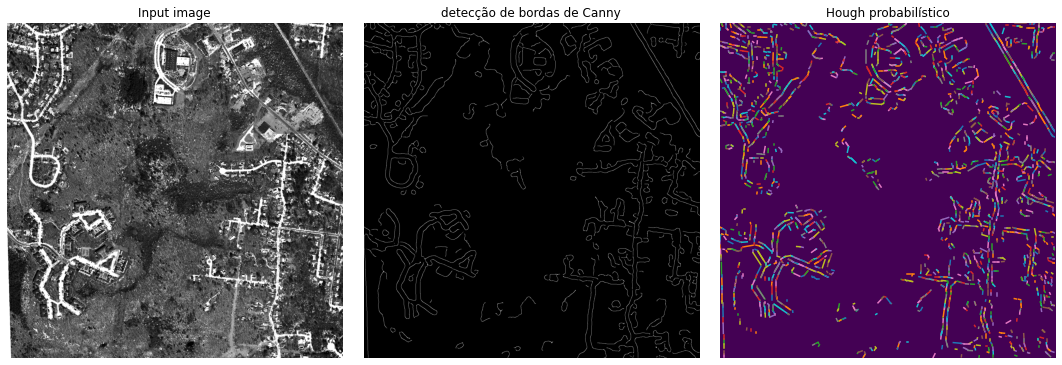

In [15]:
from skimage.transform import probabilistic_hough_line

# Line finding using the Probabilistic Hough Transform
edges = canny(image, 8, 1, 25)
lines = probabilistic_hough_line(edges, threshold=45, line_length=5,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=mpl.cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=mpl.cm.gray)
ax[1].set_title('detecção de bordas de Canny')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Hough probabilístico')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

## Our next trial method is based on region growing using an iterative implementation of a floodfill method (because of the size of the images, a recursive implementation requires huge ammounts of memory to store all function calls) using a tolerance value to serve as borders. 

In [16]:
def distance(a, b):
    return np.abs(a-b)

def is_zero(grid, row, col):
        # Helper method for checking whether the pixel belongs to an island or not
        if (row < 0 or row > len(grid) - 1):
            return False

        if (col < 0 or col > len(grid[0]) - 1):
            return False

        if grid[row][col] == 0:
            return True
        else:
            return False

def region_growing_average(img, img_t, tolerance, seed):
    #img_t = np.zeros(img.shape)
    x = seed[0]; y = seed[1]
    
    grid = np.zeros((1500, 1500))
    grid[x,y] = -1
    q = []  # init empty queue (FIFO)
    q.append([x,y])  # add to queue

    while len(q) > 0:        
        [cur_x, cur_y] = q[0]
        del q[0]
        
        avg = np.mean(img[np.where(img_t==1)])

        img_t[cur_x, cur_y] = 1

        if (is_zero(grid, cur_x-1, cur_y) == True and distance(avg, img[cur_x-1,cur_y]) <= tolerance):
            grid[cur_x-1][cur_y] = -1
            q.append([cur_x-1, cur_y])

        if (is_zero(grid, cur_x+1, cur_y) == True and distance(avg, img[cur_x+1,cur_y]) <= tolerance):
            grid[cur_x+1][cur_y] = -1
            q.append([cur_x+1, cur_y])

        if (is_zero(grid, cur_x, cur_y-1) == True and distance(avg, img[cur_x,cur_y-1]) <= tolerance):
            grid[cur_x][cur_y-1] = -1
            q.append([cur_x, cur_y-1])

        if (is_zero(grid, cur_x, cur_y+1) == True and distance(avg, img[cur_x,cur_y+1]) <= tolerance):
            grid[cur_x][cur_y+1] = -1
            q.append([cur_x, cur_y+1])
            
    return img_t

## We iteratively apply region growing to the image with randomly selected pixels as starting points, where the sample space is restricted to pixels which were previously selected as road pixels with the thresholding method.

In [ ]:
#gera a matriz output do floodfill
#escolhemos a seed aleatoriamente entre os pixels da imagem e cobrimos toda a imagem
#n vezes

img_seed = np.zeros(image.shape)

n = 40
x, y = 300, 300
for i in range(n):
    while img_o[x,y] != 1:
        x = np.random.randint(0, 1500)
        y = np.random.randint(0, 1500)
    img_seed = region_growing_average(image, img_seed, 10, [x,y])
    print(i, " ", end="")
    x = np.random.randint(0, 1500)
    y = np.random.randint(0, 1500)

plt.figure(figsize=(12,6))
plt.subplot(121); plt.imshow(image,cmap="gray"); plt.axis('off')
plt.subplot(122); plt.imshow(img_seed*255, cmap="gray"); plt.axis('off');

/home/baldissera/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3332: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/baldissera/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0  1  2  3  4  

O flood fill teve resultados aquém dos anteriores por Hough e Canny. Isso pode se dever à dificuldade de estabelecer seeds promissoras, a quantidade de pixels a serem testados para tanto e

In [ ]:
#1) segmentaremos as imagens em imagens menores 256x256, o que facilitará encontrar thresholds apropriados
#para detecção e flood fill de estradas
#2) 